<a href="https://colab.research.google.com/github/VGuzz/2022_ML_Earth_Env_Sci/blob/main/S7_1_CNNs_exercises_Vincenzo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Chapter 14 – Deep Computer Vision Using Convolutional Neural Networks**

<center>
<img width = 98% src='https://unils-my.sharepoint.com/:i:/g/personal/tom_beucler_unil_ch/EaAJAP-MWHJFiDTIcFJCnosBfaLTxi3RC_kh2ixpFwE9QA?download=1'>
<img width=49% src='https://unils-my.sharepoint.com/:i:/g/personal/tom_beucler_unil_ch/ES_kuYGy9jlPjh907YZLACsBGIhmf0wNyBG3pld1ihMlww?download=1'>
<img width=49% src='https://unils-my.sharepoint.com/:i:/g/personal/tom_beucler_unil_ch/EUwL006o7nZHproboSn_1D4Bn0SqBPk0DO5wVXkMjlC9HA?download=1'> 

Top: Picture of Shinkyo Bridge in Nikko (日光の神橋) (2010), ©Milton Gomez 😀<br>
Bottom: Style transfers based on the above image, using Google's [Deep Dream Generator](https://deepdreamgenerator.com/) </center>

Convolutional networks find spatial relationships in multidimensional data (most often images), which allow computers to detect patterns to make predictions or modify the input images in surprising ways. The following image shows a series of feature map visualizations for a convolutional neural network.

<center> <img  width=70% src='https://unils-my.sharepoint.com/:i:/g/personal/tom_beucler_unil_ch/EZQZFWrxlBFJmpm0l1qCLa8Bt3kner5j-WzuihnVzl6GKA?download=1'></center>

The images may not seem immediately relevant at first glance without knowing a bit more about the input. For example, with the picture of a cat as an input the CNN could extract features related to the eyes, ears, or details as fine as pupil types!

<center> <img width=80% src='https://unils-my.sharepoint.com/:i:/g/personal/tom_beucler_unil_ch/ESvbciKRAVtJnuLKQShuVcwBrITboypDhC2AhQUlou8aHQ?download=1'></center> 

For the style transfer examples shown at the beginning of the notebook, the original image is transformed so that it looks similar to a target style image (not shown) until they're virtually indistinguishable using the information from the filters.

<center> <img width=80% src='https://unils-my.sharepoint.com/:i:/g/personal/tom_beucler_unil_ch/EWUesyFYz6lKvQ62r9LA1DoBA6UVaGUGJAkhSj2SLfQ3yA?download=1'>

Convolution Visualization images from:
Qin, Z., Yu, F., Liu, C., & Chen, X. (2018). How convolutional neural network see the world-A survey of convolutional neural network visualization methods. [*arXiv preprint arXiv:1804.11191*](https://arxiv.org/pdf/1804.11191.pdf?ref=https://githubhelp.com).

# Notebook Setup

Today we'll be training CNNs, a process which can be very slow when run on a CPU. Instead, we'll be relying on GPU processing! Thankfully, we can easily make the switch on Colab! 

(If you're running the notebooks on your own computer, you *may* have to jump through a few hoops in order to take advantage of your computer's GPU)

***Do note, however, that access to GPUs on Colab is somewhat limited - running your model's training too many times may limit your access to the GPU resources at Google.***

###Changing the Runtime to GPU on Colab
<center>
<img src='https://unils-my.sharepoint.com/:i:/g/personal/tom_beucler_unil_ch/EWNo250Zu5hBnx9QjuPtNiQB8taogMkrLcrrP7calTARyw?download=1' border=1px><br>Click on the <i>runtime</i> dropdown menu and click on "change on runtime type"<br><br>
<img src='https://unils-my.sharepoint.com/:i:/g/personal/tom_beucler_unil_ch/EXf6kLhNEF1AtpZKquVXEuQByKKbFy8PFi0pn-Ivisi1DQ?download=1'border=1px><br>THen select "GPU" on the hardware accelerator dropdown menu<br><br>
</center>

Once you've changed the runtime type, run the Notebook setup cell. A message confirming that you've succesfully changed runtime type should be printed 😃

In the setup cell, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We'll also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")
else:
    print(f"GPU runtime succesfully selected! We're ready to train our CNNs.")

# Common imports
import numpy as np
import os
import pooch

# to make this notebook's output stable across runs
rnd_seed = 42
rnd_gen = np.random.default_rng(rnd_seed)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Loading Tensorboard
%load_ext tensorboard

GPU runtime succesfully selected! We're ready to train our CNNs.


# Data Setup

Today, we won't be working on the MNIST dataset! Instead, we'll be working on the [tensorflow flower database](https://knowyourdata-tfds.withgoogle.com/#tab=STATS&dataset=tf_flowers), and we'll be attempting to train a Neural Network to learn to classify the flowers into 1 of 5 flower species: daisies, dandelions, roses, sunflowers, and tulips. 

Let's begin by loading the data into our colab environment. The data is hosted online and loaded directly into Google's servers (if you're running this notebook on Colab, that is!) - which is lucky since its about two-hundred megabytes of data and we can take advantage of Google's servers' download speeds 🤖



In [ ]:
# Let's clear out the backend and set our random seeds
# Consistency makes things easier for labs!
keras.backend.clear_session()
tf.random.set_seed(rnd_seed)
np.random.seed(rnd_seed)

### **Q1) Load the `tf_flowers` dataset from Tensorflow. Split it into a training, validation, and test set. Make sure you save the dataset information (it will be useful for sampling the datasets), and shuffle the files for good measure!**

*Hint 1: Tensorflow Datasets was imported as `tfds` in the notebook setup. Check out the `tfds.load()` method [on the documentation](https://www.tensorflow.org/datasets/api_docs/python/tfds/load).*

*Hint 2: If you use the `.load()` method with `with_info` set to `True`, the function will return the requested datasplit in a tuple with the dataset information as a separate variable.*

*Hint 3: The datasets are loaded with `as_supervised` set to `False` by default, which requries that we worry about dictionaries when trying to access the data. We can make our lives easier by setting it to `True`*

*Hint 4: The dataset we'll be using today includes a single `train` set, but by specifying the `split` list we can tell `tfds` how we want it to split that data. We can also use percentages in the indeces to indicate which percent of the dataset to take into the dataset.* 

*Hint 5: [Here](https://unils-my.sharepoint.com/:t:/g/personal/tom_beucler_unil_ch/EaTNGGvVfGZPkp_REy_euTIB9ffE5rimlGdBIBDszOsaug?download=1) is one implementation example :)*

In [ ]:
(train, valid, test), info = tfds.load(
                name="tf_flowers", 
                split=["train[:70%]", "train[70%:85%]", "train[85%:]"],
                as_supervised=True, 
                shuffle_files=True,
                with_info=True
                )

# Datasets loaded this way don't have a string ID to identify them, so we'll set
# up our own as it will make other code more compact/readable. :)
train.name='Training'
valid.name='Validation'
test.name='Test'

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]


Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


We now have a set of variables that have the training, validation, and test sets, as well as a variable with the information about the dataset. Let's go ahead and define a function that will let us visualize our data.

### **Q2) Define a function that takes in a dataset and the information about the dataset, prints out how many samples are in the dataset, and displays a set of samples from the dataset.**

*Hint 1: Tensorflow datasets include a `.cardinality()` method that counts the number of datapoints in the dataset, and a `.numpy()` method that converts the resulting value to a numpy array for clean print access*

*Hint 2: We defined the `.name()` attribute for each dataset in the previous cell!*

*Hint 3: tfds includes a `show_examples` method. [Here is the documentation](https://www.tensorflow.org/datasets/api_docs/python/tfds/visualization/show_examples).*

*Hint 4: You can shuffle the contents of a dataset by calling its `.shuffle()` method. Try running it with an integer value between 16 and 256 as an argument.*

*Hint 5: `show_examples` expects a set of (dataset) and (dataset info) objects as argumnets!*

In [ ]:
def dataset_info(data, info):
    # Extract the number of samples in the dataset in an easily printable format 
    num_samples = data.cardinality().numpy() 
    
    # Print the dataset name we defined in the previous code cell and the number
    # of samples
    print(f"\n{data.name} set contains {num_samples} data samples.",
          "Let's visualize some of them...\n")
    
    # Show examples from the dataset. Shuffle to make things more interesting!
    tfds.show_examples(data.shuffle(16,256), info)

And now let's run the function on each of our training, validation, and test sets...

### **Q3) Run your defined visualization function on each of the training, validation, and test sets.**


Training set contains 2569 data samples. Let's visualize some of them...



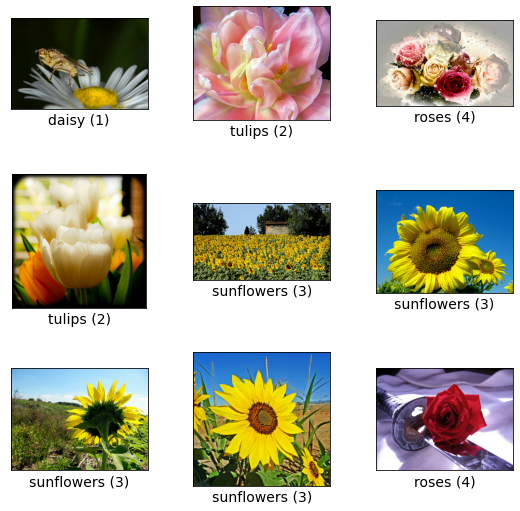


Validation set contains 551 data samples. Let's visualize some of them...



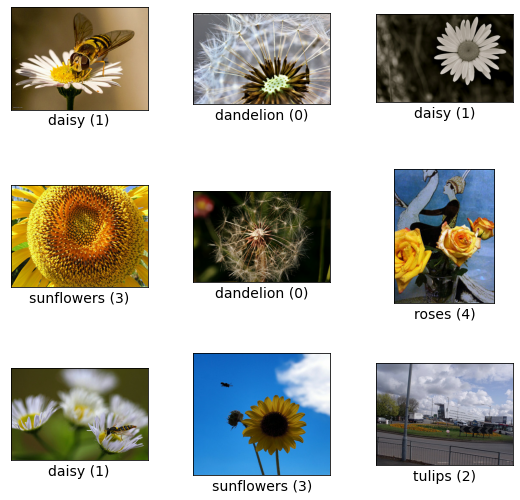


Test set contains 550 data samples. Let's visualize some of them...



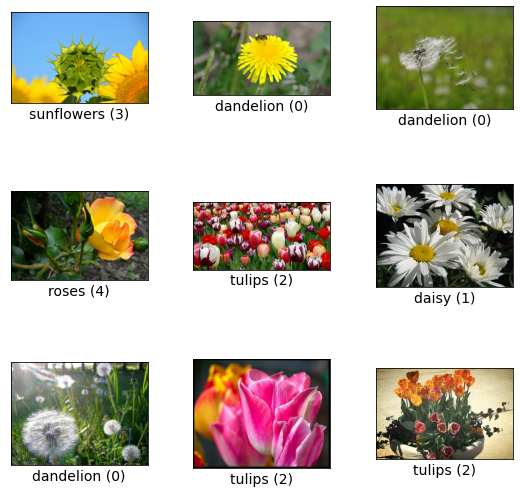

In [ ]:
dataset_info(train, info)
dataset_info(valid, info)
dataset_info(test, info)

If everything worked out fine, you'll have something like the following as your output:
<center> <img src='https://unils-my.sharepoint.com/:i:/g/personal/tom_beucler_unil_ch/ETTy292DtS5OqgLi8ZiOR0EBcJ9MQNeJIZEdiaDx0may7Q?download=1' border=1px></center>

The flowers look very nice! ("*And I'd be pretty bad at classifying them myself...*" - a botanically challenged TA) 

However, there is one sore point for our purposes - *the images have different resolutions*. Why is this a sore point? Well, in our architecture we'll eventually flatten our convolutions and connect them to a dense layer, and as such we will need for all of the images to have the same dimensions! (There are other ways to address the issue of resolution, but we won't discuss these for now)

We also note that the images are stored as pixels containing a value between 0 and 255 for each one of three color channels (RGB) - we'd prefer that the values be normalized to fall between 0 and 1.

Finally, if you paid close attention to the labels on the nice images we displayed you may have noticed that there is a number between 0 and 4 next to the name of each of the flowers - this is the integer value associated with the label. We've previously seen, however, that when addressing classification problems it's often better to use one-hot encoding.

Let's write a preprocessing function that will help us address all of these issues! 

### **Q4) Write a preprocessing function for the images and labels in our dataset. The function should set the image size to 128x128, normalize the pixel values to be between 0 and 1, and one-hot encode the labels**

*Hint 1: As we've set the `as_supervised` argument as `True` when loading the dataset, the preprocessing function should take in an image and a label as an argument.* ***Any other parameters taken in by the function should be hardcoded into our function.***

*Hint 2: In order to modify the image fed into the function, we will have to convert it to a `float32` type using Tensorflow's `.cast()` method ([here is its documentation](https://www.tensorflow.org/api_docs/python/tf/cast)). Similarly, we need to cast the label as an `int32` type object.*

*Hint 3: Tensorflow has a built-in image resizer, implemented as the `image.resize()` method. [Here is the documentation](https://www.tensorflow.org/api_docs/python/tf/image/resize).*

*Hint 4: Tensorflow has a built-in one-hot encoder, implemented as the `one_hot()` method. [Here is the documentation](https://www.tensorflow.org/api_docs/python/tf/one_hot)*

*Hint 5: After one-hot encoding, the label should be recast to the `float32` datatype*

*Hint 6: [Here](https://unils-my.sharepoint.com/:t:/g/personal/tom_beucler_unil_ch/EU9Q2EAs6qhCkFWovbIGorIBjqEJPsIeFnK88_kZgvAarg?download=1) is an implementation of the function*

In [ ]:
def preprocessing_function(image, label):
    # We're going to hard code the image size we want to use. We can define this
    # with a lambda function, but we won't really need to change this and it's
    # more trouble than it's worth for us right now :)
    image_size = 128
    num_classes = 5
    
    # Cast the image and label datatypes
    image = tf.cast(image, tf.float32)
    label = tf.cast(label,tf.int32)

    # Normalize the pixel values. Use a float value in the denominator!
    image = image / 255.0
    
    # Resize the image
    image = tf.image.resize(image, (image_size, image_size))

    # Casts to an Int and performs one-hot ops
    label = tf.one_hot(tf.cast(label, tf.int32), num_classes)
    # Recasts it to Float32
    label = tf.cast(label, tf.float32)
    
    return image, label

### **Q5) Apply the preprocessing function to each of the training, validation, and test sets.**

*Hint 1: the datasets have a `.map()` method that allow applying a function to each image and label combination in the dataset. [Here is the documentation](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map).*

In [ ]:
train = train.map(preprocessing_function)
valid = valid.map(preprocessing_function)
test = test.map(preprocessing_function)

At this point I'd also like to point out that our dataset is not set up to be taken in batches. If you call `train_set.take(1)`, you'll extract a single image! (Let's run some code and verify this)

In [ ]:
for images, labels in train.take(1):
  print(f'Images shape: {images.numpy().shape} Labels: {labels.numpy().shape}')

Images shape: (128, 128, 3) Labels: (5,)


We actually want to work in 32 image batches, so let's go ahead and batch our datasets.

### **Q6) Batch each of the training, validation, and test sets**

*Hint 1: You can define a `batch_size` variable to guarantee that the batch size is updated for all three datasets if you change the value and rerun the cell.*

*Hint 2: Tensorflow datasets include a `.batch()` method that allows you to easily define batch sizes associated with the database instance. [Here is the documentation](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch)*.

In [ ]:
# Define the batch size
batch_size = 32

train = train.batch(batch_size)
validation = valid.batch(batch_size)
test = test.batch(batch_size)

If we now take a sample like we did before, we'll notice that the first dimension in the shape tuple is our batch size!

Images shape: (32, 128, 128, 3) Labels: (32, 5)
Max pixel value: 1.0, min pixel value: 0.0
Here's a sample image:



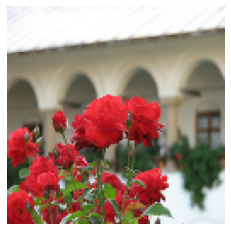

In [ ]:
for images, labels in validation.take(1):
  print(f'Images shape: {images.numpy().shape} Labels: {labels.numpy().shape}')
  print(f'Max pixel value: {images.numpy().max()}, min pixel value: {images.numpy().min()}')
  print("Here's a sample image:\n")
  fig,ax = plt.subplots()
  ax.axis('off')
  ax.imshow(images[0])


Now that we've verified that our data generators work as intended, let's go ahead and build our model!

# Model Setup and Training

Let's begin by setting up everything we need to define our callbacks! This time, we want to work with multiple runs, and in order to visualize them in Tensorboard we'll want to generate the name automatically using the current date and time!

###**Q7) Define a function that returns a filepath with the format `'./CNN_logs/run_CURRENT-DATE-AND-TIME'`**

*Hint 1: Numpy includes a method to return the current date and time as a datetime64 object. Call the `datetime64` method with `'now'` as an argument.*

*Hint 2: The OS library, imported as `os` in the notebook setup, allows you to join path strings in a manner appropriate to the operating system using the `os.path.join()` method. This helps avoids headaches when running code across windows/linux/macOS! [Here is the documentation](https://docs.python.org/3/library/os.path.html#os.path.join)*.

*Hint 3: You can use the `.astype()` method to convert a numpy datetime64 object to a string.*

*Hint 4: OS also includes a `.curdir` attribute that returns the current directory.*

*Hint 5: If you convert the datetime64 object to a string, it will include the seconds! You can remove these with regular python indexing (i.e., [:-3])*

In [ ]:
def get_CNN_logdir():
    time = np.datetime64('now').astype('str')
    run_logdir = os.path.join(os.curdir, "CNN_logs", f"run_{time}") # time goes in the fstring
    return run_logdir

Let's try out our function! It should return something like: `./CNN_logs/run_2022-04-10T18:49`

In [ ]:
get_CNN_logdir()

'./CNN_logs/run_2022-04-24T13:30:33'

Define your [callbacks](https://keras.io/api/callbacks/) below. For the checkpoint `checkpoint_cb`, we recommend monitoring the validation loss to avoid overfitting. Look for "monitor" in the `model_checkpoint`'s documentation [at this link](https://keras.io/api/callbacks/model_checkpoint/).


###**Q8) Set up an EarlyStopping Callback, a ModelCheckpoint callback, and a Tensorboard Callback for a CNN model *without* data augmentation.**

*Hint 1: [Here is the documentation](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) for the EarlyStopping Callback and [here is the one](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) for the ModelCheckpoint Callback.*

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("CNN_unaugmented.h5", 
                                                   save_best_only=True,
                                                   monitor='val_loss')
tensorboard_cb = tf.keras.callbacks.TensorBoard(get_CNN_logdir())

We now have a set of callbacks to call during training. Let's go ahead and define the model! Though let's go ahead and clean up our random states first...

In [ ]:
# Let's clear out the backend and set our random seeds.
# Consistency is key :)
keras.backend.clear_session()
tf.random.set_seed(rnd_seed)
np.random.seed(rnd_seed)

###**Q9) Define a convolutional neural network model. Do not use data augmentation techniques! We want to use this same architecture + data augmentation later.**

*Hint 1: [Here is the documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) for the Conv2D layer in tensorflow. Generally, you want to start out with larger kernels and a smaller number of filters and move on to smaller kernels with a large number of filters as your network becomes deeper.*

*Hint 2: After the convolutional layers, you can use flatten to change the collection of filtered images into a flat array to feed into a densely connected layer! In essence, the CNN is representing the images in a* ***latent space*** *, and a densely connected ANN is connected on top to classify the images based on their representation in the latent space.*

*Hint 3: Once your model is defined, we'll be using the `.build()` and `.summary()` methods to check how many parameters our model includes! A TA's model included around 13 million parameters when testing this notebook! This is significantly more parameters than the amount used when we trained our first artificial neural networks.*

*Hint 4: [Here is the code](https://unils-my.sharepoint.com/:t:/g/personal/tom_beucler_unil_ch/Ec8EhszYwTZJoicjydpezOABhTOfpJdXYJYaWj1SZEnusg?download=1) for the model trained during notebook testing...*

In [ ]:
model = keras.models.Sequential([
    # Convolution 1
    keras.layers.Conv2D(32, kernel_size=7, padding="same", activation="relu"),
    keras.layers.MaxPool2D((3,3)),

    # Convolution 2
    keras.layers.Conv2D(64, kernel_size=5, padding="same", activation="relu"),
    keras.layers.MaxPool2D((2,2)),
    
    # Convolution 3
    keras.layers.Conv2D(96, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D((2,2)),

    # Convolution 4
    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D((2,2)),

    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(5, activation="softmax")
])

In [ ]:
# Build the model using our input image resolution to produce the number of
# parameters in our model...
model.build((None, 128 , 128, 3))

# And visualize the structure of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      4736      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 42, 42, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 96)        55392     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 96)       0

###**Q10) Compile the CNN model. We recommend using  `categorical_crossentropy` as the loss function, 'adam' as the optimizer, and 'accuracy' as a metric**

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

###**Q11) Train the CNN model!**

*Hint 1: You can use the training data generator directly as your input and labels; the model class will automatically deal with it!*

*Hint 2: While it's best to have defined too many epochs instead of too few (considering that the have an early stopping callback), it's not worth training over a large number of epochs for this project. Try setting the epoch limit somewhere around 30-50.*

In [20]:
history = model.fit(train, # Training data generator
                    epochs=35,
                    validation_data=validation, # Validation data generator
                    callbacks=[early_stopping_cb,
                               checkpoint_cb,
                               tensorboard_cb])

Epoch 1/35
81/81 [==============================] - 24s 108ms/step - loss: 1.3650 - accuracy: 0.4005 - val_loss: 1.1288 - val_accuracy: 0.5390
Epoch 2/35
81/81 [==============================] - 7s 92ms/step - loss: 1.1013 - accuracy: 0.5543 - val_loss: 1.0096 - val_accuracy: 0.6062
Epoch 3/35
81/81 [==============================] - 7s 87ms/step - loss: 0.9622 - accuracy: 0.6209 - val_loss: 1.0122 - val_accuracy: 0.6098
Epoch 4/35
81/81 [==============================] - 8s 94ms/step - loss: 0.8871 - accuracy: 0.6598 - val_loss: 0.9106 - val_accuracy: 0.6788
Epoch 5/35
81/81 [==============================] - 7s 89ms/step - loss: 0.7974 - accuracy: 0.6820 - val_loss: 0.9807 - val_accuracy: 0.6570
Epoch 6/35
81/81 [==============================] - 7s 84ms/step - loss: 0.6958 - accuracy: 0.7271 - val_loss: 1.0213 - val_accuracy: 0.6443
Epoch 7/35
81/81 [==============================] - 7s 86ms/step - loss: 0.6370 - accuracy: 0.7610 - val_loss: 1.0402 - val_accuracy: 0.6425
Epoch 8/35


Well, the performance of our CNN is likely underwhelming. This is what we saw during notebook development:
<center> <img src='https://unils-my.sharepoint.com/:i:/g/personal/tom_beucler_unil_ch/EXKV6_5IGF9AiXzgNn2jJbMBXP5w3bUnuQ_q24-ZtQkS9w?download=1' border=1px></center>

The model didn't have too hard a time learning on the training set, but the validation loss quickly diverged and we started overfitting our training data. 😯

A common way to try to address this is by augmenting our training data - we can flip and rotate our images and it shouldn't make too large a difference. 

> "A rose by any other name would smell as sweet" - *Shakespeare*

> "An upside down rose is still a rose" - *A significantly less talented poet than Shakespeare*

In [21]:
# Let's clear out the backend and set our random seeds
# It's best to start out from a common point, no?
keras.backend.clear_session()
tf.random.set_seed(rnd_seed)
np.random.seed(rnd_seed)

###**Q12) Set up an EarlyStopping Callback, a ModelCheckpoint callback, and a Tensorboard Callback for a CNN model with data augmentation.**

*Hint 1: [Here is the documentation](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) for the EarlyStopping Callback and [here is the one](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) for the ModelCheckpoint Callback.*

In [22]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("CNN_augmented.h5", 
                                                   save_best_only=True,
                                                   monitor='val_loss')
tensorboard_cb = tf.keras.callbacks.TensorBoard(get_CNN_logdir())

### **Q13) Train an identical model to that defined in Q9, with the exception of `RandomFlip` and `RandomRotation` augmentation layers added before the convolutional layers.**

*Hint 1: [Here is the documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomFlip) for the `RandomFlip` method.*

*Hint 1: [Here is the documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomRotation) for the `RandomRotation` method.*

In [25]:
model = keras.models.Sequential([
    keras.layers.RandomFlip(), # Flip augmentation
    keras.layers.RandomRotation(0.1), # Rotation Aumentation

    # Copy your previous model's layers here
    # Convolution 1
    keras.layers.Conv2D(32, kernel_size=7, padding="same", activation="relu"),
    keras.layers.MaxPool2D((3,3)),

    # Convolution 2
    keras.layers.Conv2D(64, kernel_size=5, padding="same", activation="relu"),
    keras.layers.MaxPool2D((2,2)),
    
    # Convolution 3
    keras.layers.Conv2D(96, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D((2,2)),

    # Convolution 4
    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D((2,2)),

    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(5, activation="softmax")
])

In [26]:
# Build the model using our input image resolution to produce the number of
# parameters in our model...
model.build((None, 128 , 128, 3))

# And visualize the structure of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, 128, 128, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 128, 128, 3)      0         
 tation)                                                         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      4736      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 42, 42, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 64)      

###**Q14) Compile the CNN model. We recommend using  `categorical_crossentropy` as the loss function, 'adam' as the optimizer, and 'accuracy' as a metric**

In [28]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [29]:
history = model.fit(train, # Training data generator
                    epochs=35,
                    validation_data=validation, # Validation data generator
                    callbacks=[early_stopping_cb,
                               checkpoint_cb,
                               tensorboard_cb])

Epoch 1/35
81/81 [==============================] - 9s 95ms/step - loss: 1.3713 - accuracy: 0.3768 - val_loss: 1.2092 - val_accuracy: 0.4846
Epoch 2/35
81/81 [==============================] - 8s 92ms/step - loss: 1.1574 - accuracy: 0.5177 - val_loss: 1.0922 - val_accuracy: 0.5626
Epoch 3/35
81/81 [==============================] - 8s 96ms/step - loss: 1.0482 - accuracy: 0.5780 - val_loss: 1.1367 - val_accuracy: 0.5554
Epoch 4/35
81/81 [==============================] - 8s 94ms/step - loss: 0.9579 - accuracy: 0.6248 - val_loss: 1.0704 - val_accuracy: 0.5590
Epoch 5/35
81/81 [==============================] - 8s 93ms/step - loss: 0.9351 - accuracy: 0.6345 - val_loss: 0.9934 - val_accuracy: 0.6171
Epoch 6/35
81/81 [==============================] - 7s 87ms/step - loss: 0.8813 - accuracy: 0.6563 - val_loss: 1.0326 - val_accuracy: 0.6025
Epoch 7/35
81/81 [==============================] - 7s 91ms/step - loss: 0.8561 - accuracy: 0.6684 - val_loss: 0.9176 - val_accuracy: 0.6443
Epoch 8/35
81

If everything went according to plan, your model icluding data augmentation should perform a little like this:
<center> <img src='https://unils-my.sharepoint.com/:i:/g/personal/tom_beucler_unil_ch/EViI9ctwWN1NnEUkL-r9t9oB4nZWF3AGWXf0J2WEYS4irA?download=1' border=1px></center>

Now let's run tensorboard and compare your two runs! 

In [30]:
%tensorboard --logdir=./CNN_logs --port=6006

<IPython.core.display.Javascript object>

If everything went well, the model trained on the augmented data should have a lower accuracy on the training set compared to the original, but the behavior accross both datasets should be indicative of more meaningful features being extracted and overall better generalization. 

(While the use of augmented data is exciting, this might not be wise to do - e.g., when looking at maps of atmospheric variable data)

In [31]:
# Let's load the models!
non_aug_model = keras.models.load_model('CNN_unaugmented.h5')
aug_model = keras.models.load_model('CNN_augmented.h5')

# And test them on the testing dataset
non_aug_model.evaluate(test)
aug_model.evaluate(test)

18/18 [==============================] - 1s 37ms/step - loss: 0.6557 - accuracy: 0.7673


[0.655694842338562, 0.7672727108001709]